In [16]:

import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.io import MemoryFile
from shapely.geometry import mapping


In [2]:
name = "Lacey"

In [3]:
# Navigate to the study site data directory
# This directory should contain the DTM file and any other spatial data
os.chdir(f"../data/{name}")
print(f"Current working directory: {os.getcwd()}")

Current working directory: c:\Users\jvonnonn\Gitlab_repos\meadows\data\Lacey


## stream metrics

In [27]:
# load sinuosity and bank height data
sino = np.load(f"sino_{name}.npy")
print(f"Sinuosity: {sino}")

Sinuosity: 1.96026830894073


In [28]:
bank_height = pd.read_csv(f"bank_height_{name}.csv", index_col=0)
bank_height

,area,bank,percentage
category,,,
1,420.12,0-2 feet,27.221833
2,967.32,2-4 feet,62.677863
3,155.88,4+ feet,10.100303


## bare earth

In [30]:
## Load classified bare earth
with rasterio.open("bare_classified.tif") as src:
    bare = src.read(1)
    bare_earth_area = np.sum(bare == 1)

# Print summary
print("Bare Earth Cover (%):", round(bare_earth_area / total_area * 100, 2))

Bare Earth Cover (%): 2.6


## vegetation

In [32]:
# Load CHM again for vegetation stats
with rasterio.open(f"chm_{name}.tif") as src:
    chm = src.read(1)
    pixel_area = src.transform.a ** 2
    trees = np.sum(chm > 5) * pixel_area
    shrubs = np.sum((chm > 0.2) & (chm < 5)) * pixel_area
    total_area = np.sum(~np.isnan(chm)) * pixel_area

print("Tree Cover total across study area (%):", round(trees / total_area * 100, 2))
print("Shrub Cover total across study area (%):", round(shrubs / total_area * 100, 2))

Tree Cover total across study area (%): 2.15
Shrub Cover total across study area (%): 9.64


In [ ]:

def sum_chm_by_internal_buffers_with_export(chm_path, boundary_path, buffer_step=10,
                                    height_threshold=height_threshold, output_geojson="internal_buffers.geojson"):
    
    # Load boundary and CHM
    gdf = gpd.read_file(boundary_path)
    with rasterio.open(chm_path) as src:
        chm = src.read(1)
        #chm[chm <= 0] = np.nan
        chm_crs = src.crs

        if gdf.crs != chm_crs:
            gdf = gdf.to_crs(chm_crs)

        geom = gdf.geometry.iloc[0]

        results = []
        buffer_geoms = []
        distance = 0

        while True:
            buffered = geom.buffer(-distance)
            if buffered.is_empty or not buffered.is_valid:
            #if buffered.is_empty or not buffered.is_valid or not isinstance(buffered, Polygon):
                break

            try:
                out_image, _ = mask(src, [mapping(buffered)], crop=True, nodata=np.nan)
                out_image = np.squeeze(out_image)
                total_area = np.sum(~np.isnan(out_image))
                trees = np.nansum(out_image > height_threshold)
                #trees = np.where(out_image > height_threshold, out_image, 0)
                #total = np.sum(trees > 0)
                results.append((distance, trees, total_area))
                buffer_geoms.append(buffered)
            except ValueError:
                break

            distance += buffer_step

    # Save buffers as GeoJSON
    buffer_gdf = gpd.GeoDataFrame({'distance_m': [r[0] for r in results], f'sum_gt_{height_threshold}m': [r[1] for r in results], 'total_area': [r[2] for r in results]}, geometry=buffer_geoms, crs=chm_crs)
    buffer_gdf.to_file(output_geojson, driver="GeoJSON")

    return results, output_geojson


In [34]:
height_threshold = 5

In [17]:

results, geojson_path = sum_chm_by_internal_buffers_with_export(
    f"chm_{name}.tif",
    "meadow_extent.geojson",
    buffer_step=10,
    height_threshold=height_threshold,
    output_geojson=f"internal_buffers_{name}.geojson"
)

print(f"Saved {len(results)} internal buffers to {geojson_path}")


Saved 40 internal buffers to internal_buffers_Lacey.geojson


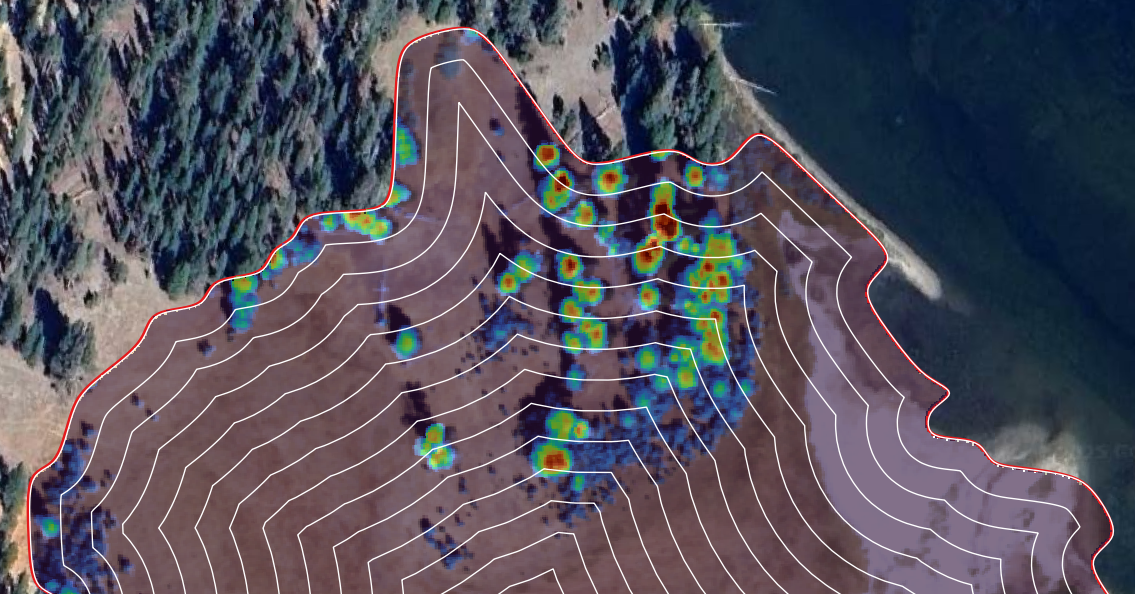

In [18]:
import pandas as pd
results_df = pd.DataFrame({'distance_m': [r[0] for r in results], f'sum_gt_{height_threshold}m': [r[1] for r in results], 'total_area': [r[2] for r in results]})

In [19]:
results_df

,distance_m,sum_gt_5m,total_area
0,0,102754,4803926
1,10,35788,4506260
2,20,21380,4210169
3,30,15514,3931402
4,40,11657,3675129
5,50,9138,3432869
6,60,6893,3208928
7,70,5084,3004023
8,80,3627,2819167
9,90,2639,2642160


In [25]:
results_df['buffer_chm_sum'] = results_df[f'sum_gt_{height_threshold}m'] - results_df[f'sum_gt_{height_threshold}m'].shift(-1)
results_df['buffer_total_sum'] = results_df.total_area - results_df.total_area.shift(-1)
results_df[f'percent_cover_{height_threshold}m'] = round(results_df.buffer_chm_sum / results_df.buffer_total_sum * 100,2)
results_df

,distance_m,sum_gt_5m,total_area,buffer_chm_sum,buffer_total_sum,percent_cover_5m
0,0,102754,4803926,66966.0,297666.0,22.50
1,10,35788,4506260,14408.0,296091.0,4.87
2,20,21380,4210169,5866.0,278767.0,2.10
3,30,15514,3931402,3857.0,256273.0,1.51
4,40,11657,3675129,2519.0,242260.0,1.04
5,50,9138,3432869,2245.0,223941.0,1.00
6,60,6893,3208928,1809.0,204905.0,0.88
7,70,5084,3004023,1457.0,184856.0,0.79
8,80,3627,2819167,988.0,177007.0,0.56
9,90,2639,2642160,530.0,172227.0,0.31


In [26]:
results_df.to_csv(f"internal_buffers_{name}.csv")

### create decision tree to categorize meadow based on these metrics

## Identifying individual trees (future work)

from scipy.ndimage import maximum_filter, label, find_objects
from skimage.feature import peak_local_max
from rasterio.plot import show

In [ ]:
#chm_data[chm_data < 4] = 0


# Detect local maxima (tree tops)
coordinates = peak_local_max(
    chm_data,
    min_distance=3,  # minimum distance between peaks (in pixels)
    threshold_abs=4,  # minimum height to be considered a tree
    #indices=True
)

# Plot CHM and detected tree tops
plt.figure(figsize=(10, 8))
#plt.imshow(chm_data, cmap='viridis')
plt.imshow(rgb_uint8)
plt.scatter(coordinates[:, 1], coordinates[:, 0], c='red', s=0.025, label='Tree Tops', alpha=0.8)
plt.title('Detected Tree Tops from CHM')
plt.show()